In [18]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import sys
import os.path
import matplotlib.pyplot as plt
import seaborn as sbn

sys.path.append(os.path.dirname("../"))

from plugins.FaxDistiller import Distill

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
raw_file = "../data/FakeWaveform_raw/XENON1T-0-000000000-000000999-000001000.zip"
truth_file = "../data/FakeWaveform_truth.csv"

### Load FAX raw data and distill down into useful parts

In [3]:
distiller = Distill(raw_file, truth_file)
distiller.load()

100%|██████████| 1000/1000 [00:01<00:00, 638.18it/s]


### The way to retrieve distilled data

In [4]:
### Distill.get() returns iterator of distilled data for the event (objects of the Condensate() class)
event = distiller.get(1).__next__()
event.get_event().head()

,baseline,channel,event_number,left,length,max_waveform_length,right,waveform
0,NaN,0,1,105438,190,190,105627,"[16000, 16004, 15998, 16005, 15999, 16005, 160..."
1,NaN,0,1,136472,102,102,136573,"[16002, 16008, 16000, 16009, 16002, 16004, 159..."
2,NaN,3,1,105438,102,102,105539,"[16003, 15999, 16004, 16000, 16006, 15999, 160..."
3,NaN,3,1,110444,102,102,110545,"[16001, 15998, 16000, 15996, 16002, 15998, 160..."
4,NaN,4,1,105420,256,256,105675,"[16009, 16010, 16011, 16006, 16012, 16006, 160..."


In [5]:
print(event.__doc__)


        Class of distilled FAX events.
        
        Methods:
            : get_events() : Returns pandas.DataFrame with core information on pulses in the event.
            : get_waveforms_in_channel() : Returns pandas.DataFrame with reconstructed waveforms per
                                           channel (pmt) for the event.
            : get_event_truth() : Returns pandas.DataFrame with FAX truth information on the event
    


### Loop over events and store distilled data for each event

In [6]:
events = []
waveforms_in_channels = []
event_truths = []

for distilled_events in distiller.get(10):
    events.append(distilled_events.get_event())  # Retrieve pandas.DataFrame of event information
    waveforms_in_channels.append(distilled_events.get_waveforms_in_channels())  # Retrieve pandas.DataFrame 
                                                                                # of per channel reconstructed 
                                                                                # waveforms in the event
    event_truths.append(distilled_events.get_event_truth())  # Retrieve pandas.DataFrame of PAX truth information for event

In [8]:
event_truths[0]

,fax_truth_peak_id,event,g4_id,instruction,n_electrons,n_photons,peak_type,repetition,t_first_electron,t_first_photon,...,t_last_electron,t_last_photon,t_mean_electrons,t_mean_photons,t_sigma_electrons,t_sigma_photons,top_fraction,x,y,z
5,5,1,-1,1,NaN,29,s1,0,NaN,6.550311e+05,...,NaN,6.551501e+05,NaN,6.550778e+05,NaN,32.208841,0.034483,2.626434,-17.960824,-57.456815
6,6,1,-1,1,32.0,764,s2,0,1.053706e+06,1.053837e+06,...,1.056341e+06,1.057203e+06,1.055127e+06,1.055459e+06,657.901854,678.571516,0.676702,2.488824,-17.019777,-57.456815
7,7,1,-1,1,NaN,23,photoionization_afterpulse,0,NaN,1.588175e+06,...,NaN,1.588743e+06,NaN,1.588460e+06,NaN,142.841918,0.652174,47.416537,4.326025,-0.500000
8,8,1,-1,1,NaN,30,photoionization_afterpulse,0,NaN,1.063021e+06,...,NaN,1.063584e+06,NaN,1.063262e+06,NaN,139.310171,0.600000,6.501793,12.179028,-0.500000
9,9,1,-1,1,NaN,19,photoionization_afterpulse,0,NaN,1.365220e+06,...,NaN,1.365713e+06,NaN,1.365479e+06,NaN,154.385169,0.526316,-10.587970,37.731992,-0.500000
10,10,1,-1,1,NaN,21,photoionization_afterpulse,0,NaN,1.393101e+06,...,NaN,1.393944e+06,NaN,1.393371e+06,NaN,168.065879,0.666667,-15.456438,12.185898,-0.500000
11,11,1,-1,1,NaN,26,photoionization_afterpulse,0,NaN,1.394373e+06,...,NaN,1.395161e+06,NaN,1.394621e+06,NaN,192.550195,0.653846,-43.696444,0.595208,-0.500000
12,12,1,-1,1,NaN,20,photoionization_afterpulse,0,NaN,1.104477e+06,...,NaN,1.105084e+06,NaN,1.104776e+06,NaN,181.621535,0.750000,-31.802839,23.183041,-0.500000


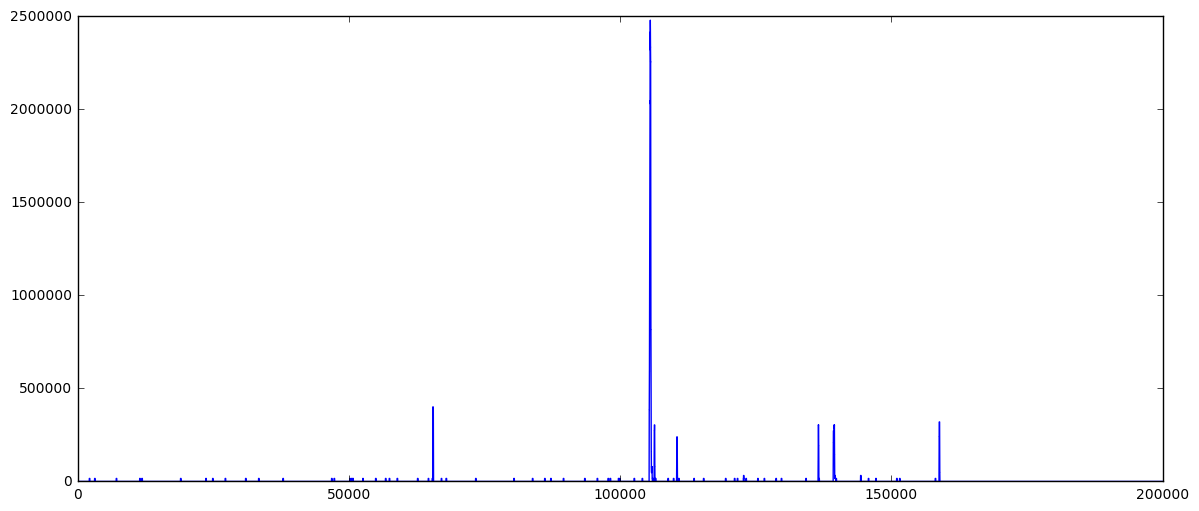

In [27]:
### Plot of waveforms for each pmt summed up

sum_waveforms = waveforms_in_channels[0].drop("event_number", axis=1).sum(axis=1)

fig = plt.figure(figsize=(14,6))
ax = plt.subplot(111)
fig = ax.plot(sum_waveforms.index, sum_waveforms)